# Analyzing Recycling Habits of UW-Madison via Oscar Sort
By Ben Schweitzer

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from ipywidgets import interact
from IPython.display import display, Markdown

## The Data
The data used in this notebook was supplied by Intuitive AI, the company that developed Oscar Sort. Oscar Sort is a smart recycling assistant that uses computer vision to identify items in the view of its camera and inform the user as to if that item is garbage or recycling. Thanks to this technology, the machine is able to identify the items being disposed of in its bin as well as what item the bin was placed in and if the item is or is not recyclable. There are four of these devices at various locations on UW-Madison's campus managed by the Office of Sustainability. The data below has been collected from all four of these on-campus machines over the course of the beginning of 2025. Each row of this data tells us how many times each item was disposed of in each bin (garbage or recycling) on each day (that data was recorded) at each location.

In [38]:
# Import the data
disposals = pd.read_csv('disposal_csv-uwisconsin(in).csv')

# Change device names to be more readable
device_location_map = {
    'uwisconsin_madison_oscarsort_1': 'U South',
    'uwisconsin_madison_oscarsort_2': 'Dejope',
    'uwisconsin_madison_oscarsort_3': 'Mem U',
    'uwisconsin_madison_oscarsort_4': 'Gordon Dining'
}
disposals['Device'] = disposals['Device'].map(device_location_map)


disposals.head()

,Date,Device,Bin,Item,Disposals,Contaminants,Correct Bin
0,1/7/2025,U South,Trash,plastic gloves,2,0,Trash
1,1/7/2025,Dejope,Trash,apple core,1,0,Trash
2,1/7/2025,Mem U,Trash,plastic wrap,1,0,Trash
3,1/14/2025,U South,Recycling,tetrapack,1,1,Trash
4,1/14/2025,U South,Recycling,wrapper,1,1,Trash


In [39]:
print(disposals.shape)

(2504, 7)


The data consists of 7 columns and 2504 rows

### Columns



In [40]:
column_names = disposals.columns
print(column_names)

Index(['Date', 'Device', 'Bin', 'Item', 'Disposals', 'Contaminants',
       'Correct Bin'],
      dtype='object')


#### Date
The day that the disposal(s) took place

In [41]:
date_min = disposals['Date'].min()
date_max = disposals['Date'].max()
print(date_min, date_max)

1/14/2025 4/8/2025


The dates covered by the data span from January 14 to April 8 of 2025

#### Device
The Oscar device that the disposal(s) was made in
(1: U South, 2: Dejope, 3: Mem U, 4: Gordon Dining)

In [42]:
print(disposals['Device'].unique())

['U South' 'Dejope' 'Mem U' 'Gordon Dining']


#### Bin
The bin that the disposal was placed in

In [43]:
print(disposals['Bin'].unique())

['Trash' 'Recycling']


#### Item
The type of item that was disposed of

The items listed below are the items labeled as **trash** by the Office of Sustainability

In [44]:
trash_items = disposals[disposals['Correct Bin'] == 'Trash']['Item'].unique()
print(trash_items)

['plastic gloves' 'apple core' 'plastic wrap' 'tetrapack' 'wrapper'
 'plastic cutlery' 'food box' 'napkin' 'plastic bag' 'coffee cup lid'
 'plastic sauce cup' 'plastic straw' 'chopsticks' 'food scraps'
 'soft plastic lid' 'liquids' 'banana peel' 'paper bowl' 'orange peel'
 'waxed food paper' 'face mask' 'stirstick' 'paper plate' 'chip bag'
 'paper plastic bag' 'receipt' 'sauce packet' 'coffee creamer cup'
 'paper lid' 'pizza box' 'paper sauce cup' 'battery' 'wooden cutlery'
 'tea bag' 'apple scraps' 'juice pouch']


The items listed below are the items labeled as **recycling** by the Office of Sustainability

In [45]:
recycling_items = disposals[disposals['Correct Bin'] == 'Recycling']['Item'].unique()
print(recycling_items)

['plastic bottle' 'plastic lid' 'plastic container' 'coffee cup'
 'plastic cup' 'coffee cup sleeve' 'paper wrapper' 'paper' 'aluminium can'
 'paper pop cup' 'paper bag' 'cardboard' 'yoghurt container'
 'aluminium foil' 'aluminium container' 'glass bottle' 'aluminium bottle'
 'paper drink tray' 'magazine']


#### Disposals
The number of times that item was disposed in that device's bin on that date

In [46]:
print(disposals['Disposals'].min(), disposals['Disposals'].mean(), disposals['Disposals'].max())

1 4.378194888178914 67


The number of disposals ranges from 1 to 67 and has a mean values of about 4.38

#### Contaminants
If the item was placed in the right bin, contaminants = 0. If placed in the wrong bin, contaminants = disposals. This column exists for ease of analysis.

In [47]:
print(disposals['Contaminants'].min(), disposals['Contaminants'].mean(), disposals['Contaminants'].max())

0 1.4404952076677315 47


The number of contaminants ranges from 0 to 47 with a mean of about 1.44

#### Correct Bin
The bin (trash or recycling) that the given item should be placed in

In [48]:
print(disposals['Correct Bin'].unique())

['Trash' 'Recycling']


## Analysis and Visualization

### Disposals Over Time

Let's start by taking a look at the trends in the number of disposals made over time

<Axes: title={'center': 'Total Disposals Per Day'}, xlabel='Date'>

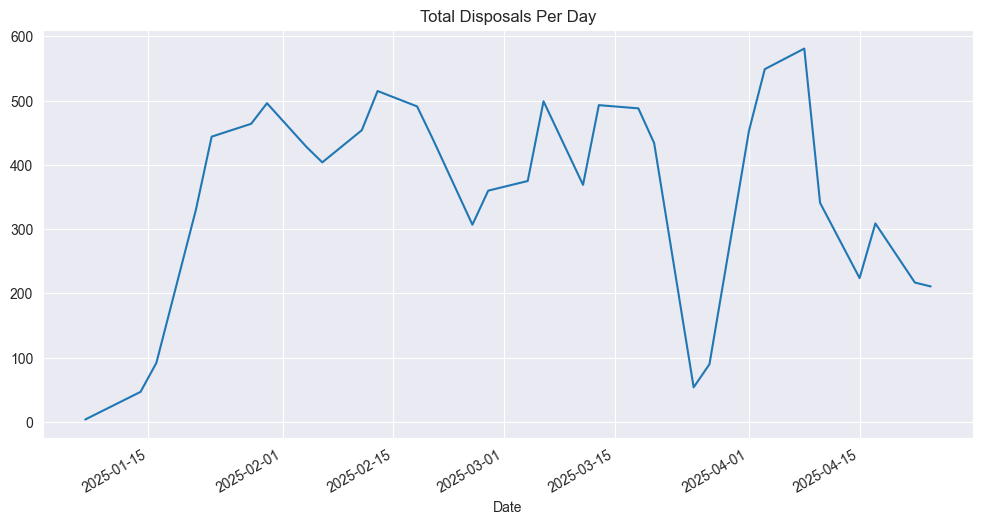

In [49]:
disposals['Date'] = pd.to_datetime(disposals['Date'])

total_disposals_per_day = disposals.groupby('Date')['Disposals'].sum()
total_disposals_per_day.plot(kind='line', figsize=(12, 6), title='Total Disposals Per Day')

We can see in the plot above that, while school is in session, the number of disposals per day hovers between 350 and 500 for the most part. The major decline at the end of March is due to Spring break (much fewer people on campus during that time).

Next, let's compare these trends to the trends in the number of contaminants per day over time.
* Note: any time contaminations are mentioned in this notebook, it refers to the number/ percentage of items that were placed in the wrong bin. In other words, it accounts for garbage placed in recycling bins and recycling placed in garbage bins.

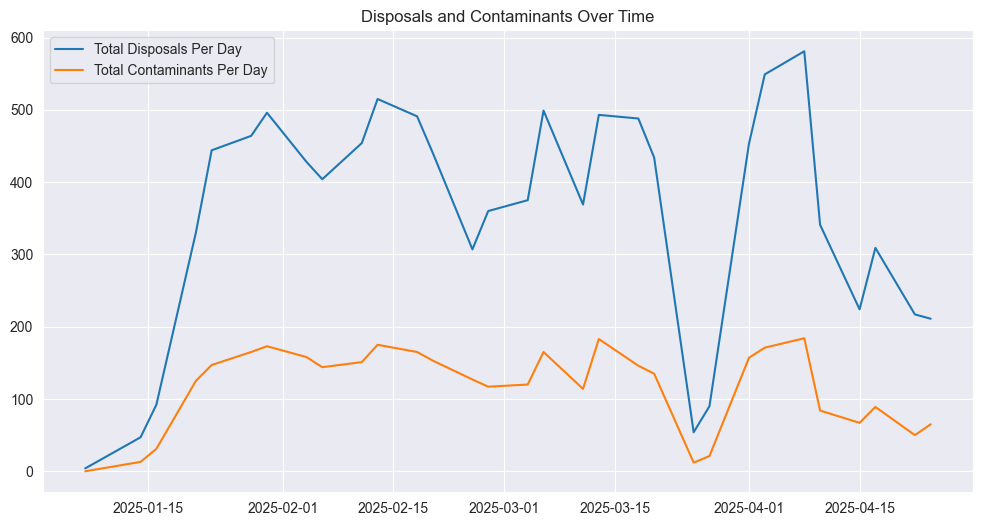

In [50]:
plt.figure(figsize=(12, 6))
total_contaminants_per_day = disposals.groupby('Date')['Contaminants'].sum()

plt.plot(total_disposals_per_day.index, total_disposals_per_day.values, label='Total Disposals Per Day')
plt.plot(total_contaminants_per_day.index, total_contaminants_per_day.values, label='Total Contaminants Per Day')
plt.title('Disposals and Contaminants Over Time')
plt.legend()
plt.show()

We can see a clear similarity in the shape of the two curves. This makes sense as the number of contaminants will always be proportional to the number of total disposals. The number of contaminants per day hovers between 100 and 200 while school is in session.

### Accuracy Over Time

Next, let's take a look at some of the trends in the accuracy rate over time. In this case, accuracy is defined as the percentage of all disposals that were placed in their correct bin.

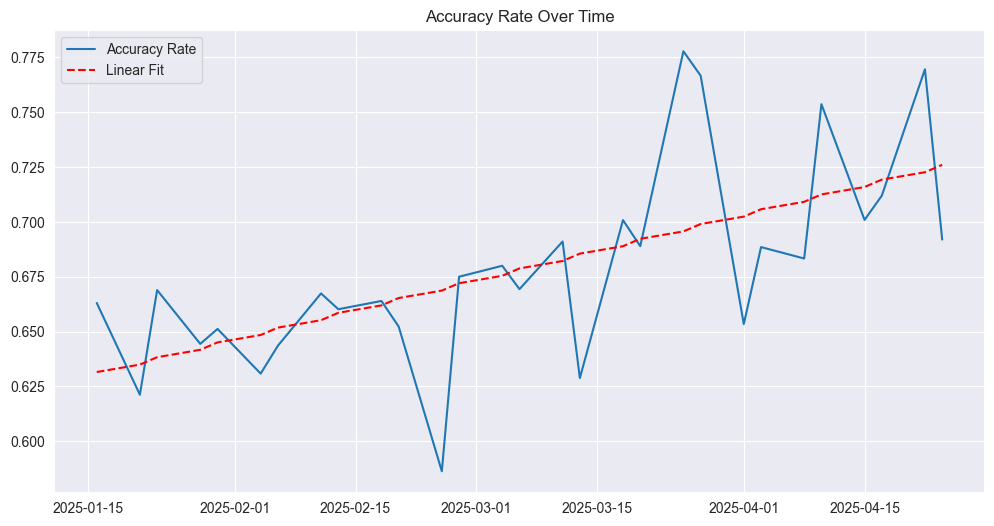

In [77]:
accuracy_rate_per_day = 1 - ((total_contaminants_per_day / total_disposals_per_day))

N = 2

x = np.arange(len(accuracy_rate_per_day))[N:]
y = accuracy_rate_per_day.values[N:]

slope, intercept = np.polyfit(x, y, 1)
trend = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(accuracy_rate_per_day.index[N:], y, label='Accuracy Rate')
plt.plot(accuracy_rate_per_day.index[N:], trend, color='red', linestyle='--', label='Linear Fit')
plt.title('Accuracy Rate Over Time')
plt.legend()
plt.show()

This plot shows the promising signs of a steadily rising accuracy rate when we plot the linear fit line of the accuracy rate over time. The optimistic explanation for this is that as those who interact with the Oscar Sort devices interact with them again and again over time and with different items, they learn more about which items belong in which bins. This is the goal of the Oscar Sort machines, so hopefully we can see the continuation of this trend going forward and continue to move towards a more sustainable campus.

Let's break this accuracy plot into trash and recycling in order to see how the two categories compare.

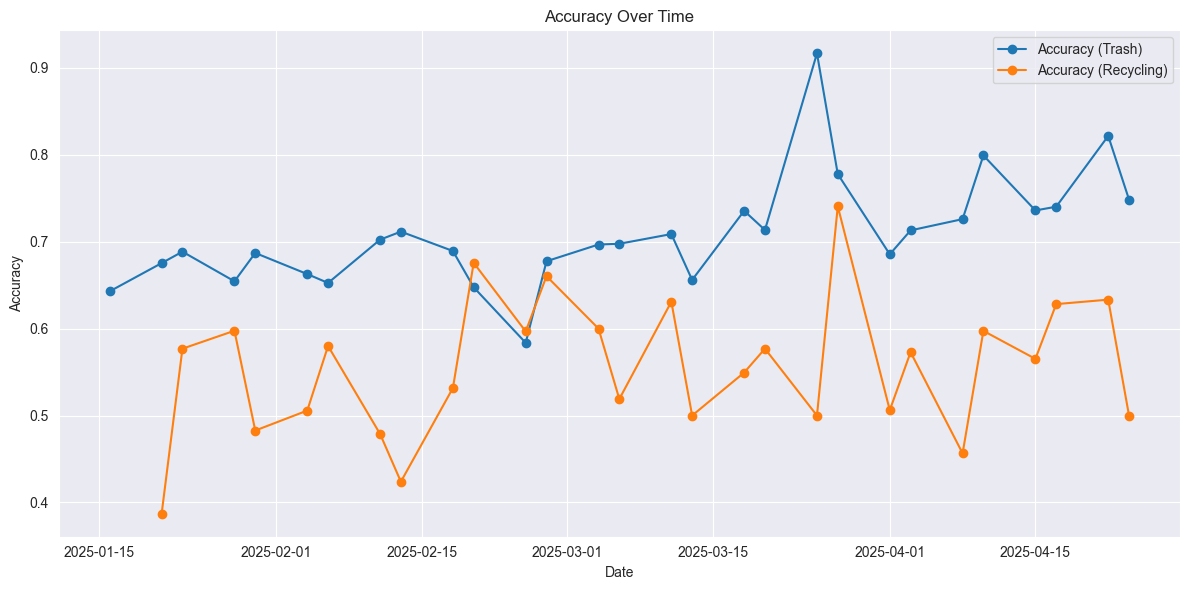

Mean trash accuracy:  0.7085595370156387
Mean recycling accuracy:  0.5562203371246486


In [98]:
disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Bin']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate accuracy
daily['Accuracy'] = 1 - (daily['Contaminants'] / daily['Disposals'])

daily = daily[4:] #Cut off early values where disposal volume was low

daily_garbage = daily[daily['Bin'] == 'Trash']
daily_recycling = daily[daily['Bin'] == 'Recycling']

plt.figure(figsize=(12, 6))
plt.plot(daily_garbage['Date'], daily_garbage['Accuracy'], marker='o', label='Accuracy (Trash)')
plt.plot(daily_recycling['Date'], daily_recycling['Accuracy'], marker='o', label='Accuracy (Recycling)')
plt.title('Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

print('Mean trash accuracy: ', daily_garbage['Accuracy'].mean())
print('Mean recycling accuracy: ', daily_recycling['Accuracy'].mean())

This plot reveals that the accuracy of disposals made into the trash bin has almost always exceeded that of disposals made into the recycling. Trash has a mean accuracy of about 71% while recycling trails behind with an average of about 56%. This suggests that recycling should be the focus of efforts to improve waste sorting in order to improve the overall disposal accuracy rate on campus.

Finally, let's see how accuracy trends differ between the four different Oscar Sort devices located around campus.

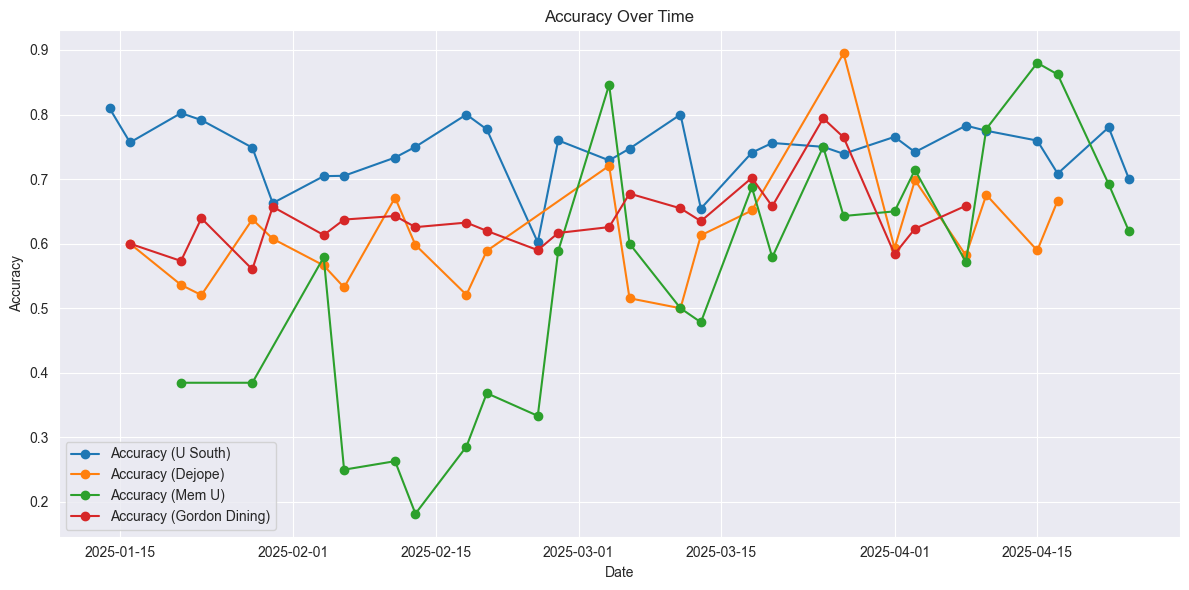

The above plot is hard to decipher due to the heavy overlap between plot lines. The plot below makes it easier to comprehend by smoothing out the lines using a rolling average

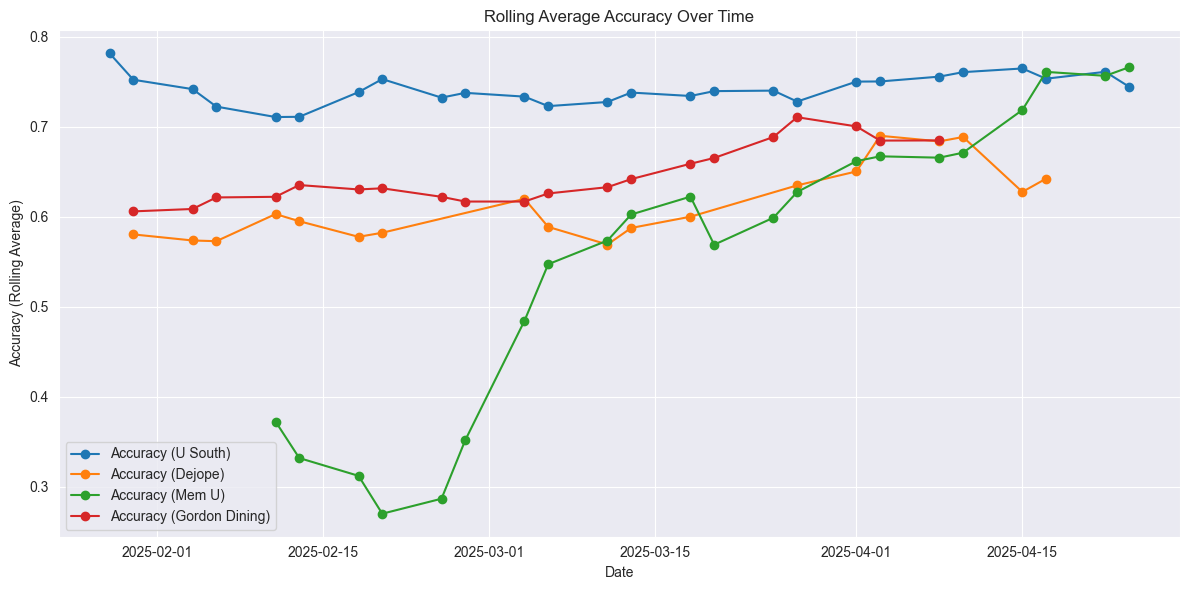

In [100]:
# Accuracy over time by location

disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Device']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate accuracy
daily['Accuracy'] = 1 - (daily['Contaminants'] / daily['Disposals'])

daily = daily[4:]

devices = disposals['Device'].unique()

plt.figure(figsize=(12, 6))

for device in devices:
    daily_device = daily[daily['Device'] == device]
    plt.plot(daily_device['Date'], daily_device['Accuracy'], marker='o', label=f'Accuracy ({device})')

plt.title('Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(("The above plot is hard to decipher due to the heavy overlap between plot lines. The plot below makes it easier to comprehend by smoothing out the lines using a rolling average")))

# Let's make the plot a lot easier to read by smoothing out the lines in the plot

plt.figure(figsize=(12, 6))

for device in devices:
    daily_device = daily[daily['Device'] == device]
    # Applies a rolling average to the y values in order to make the visualization more readable
    smoothed_accuracy = daily_device['Accuracy'].rolling(window=5).mean()
    plt.plot(daily_device['Date'], smoothed_accuracy, marker='o', label=f'Accuracy ({device})')

plt.title('Rolling Average Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy (Rolling Average)')
plt.legend()
plt.tight_layout()
plt.show()

From this visual we can reason that the device located in Union South sees the most accurate disposals on average amongst all devices. As we will see later, the device in Memorial Union sees a considerably lower amount of disposals, which is likely the cause for the much more volatile accuracy rate. Dejope and Gordon's see similar performance over time, but are still underperforming Union South on average.

In [ ]:
TODO
#Determine a conclusion to make from this observation

### Item-Level Accuracies

In [54]:
item_freqs = disposals.groupby(['Item', 'Correct Bin'])['Disposals'].sum().sort_values(ascending=False)
display(item_freqs.head(5))

Item               Correct Bin
napkin             Trash          2302
plastic cutlery    Trash          1201
plastic container  Recycling      1192
food box           Trash           756
wrapper            Trash           752
Name: Disposals, dtype: int64

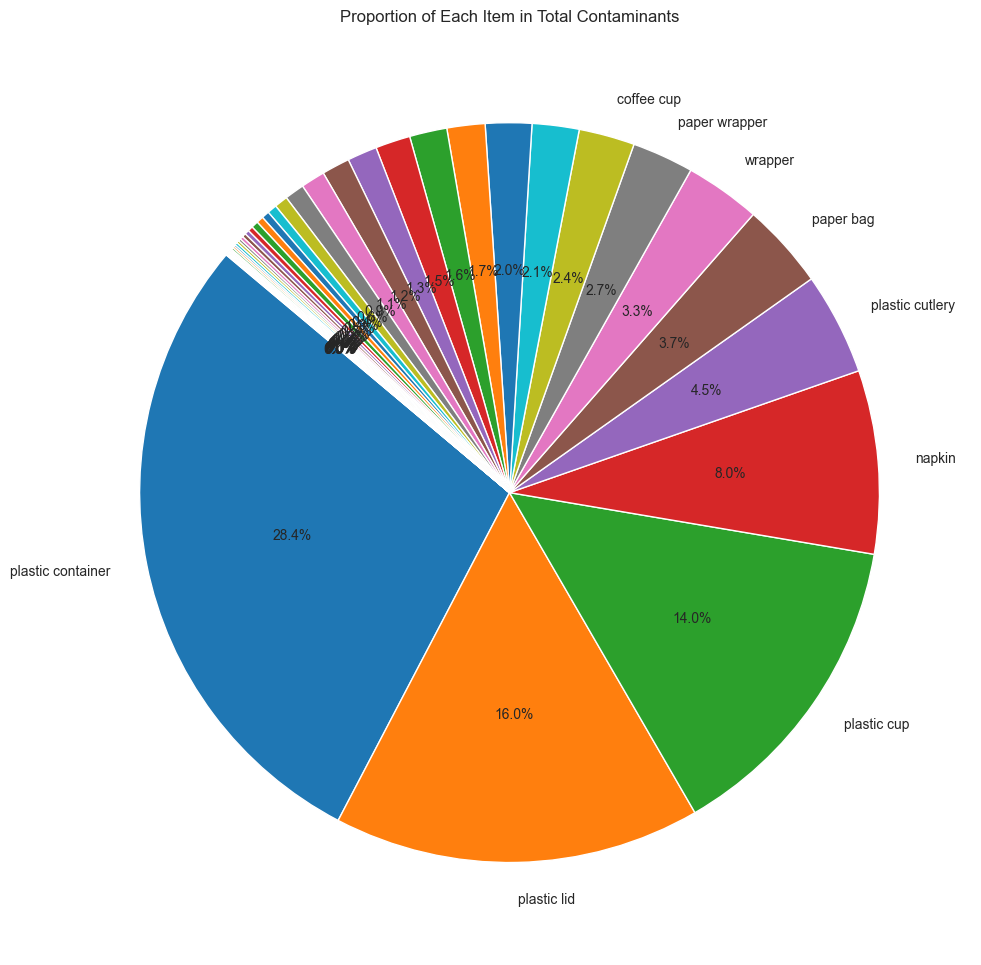

In [55]:
contaminants_by_item = disposals.groupby('Item')['Contaminants'].sum()
# Filter out items with zero contaminants (optional)
contaminants_by_item = contaminants_by_item[contaminants_by_item > 0]
contaminants_by_item = contaminants_by_item.sort_values(ascending=False)

labels = [item if value > 80 else '' for item, value in contaminants_by_item.items()]

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(contaminants_by_item, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Item in Total Contaminants')
plt.tight_layout()
plt.show()

Item Contaminant Percentages:
Item                 Correct Bin
glass bottle         Recycling      100.000000
paper drink tray     Recycling      100.000000
aluminium foil       Recycling       91.666667
paper bag            Recycling       87.662338
plastic container    Recycling       86.073826
paper pop cup        Recycling       84.615385
plastic lid          Recycling       79.724138
paper wrapper        Recycling       76.984127
plastic cup          Recycling       74.777448
coffee cup sleeve    Recycling       69.767442
yoghurt container    Recycling       66.666667
tetrapack            Trash           53.846154
aluminium container  Recycling       50.000000
paper                Recycling       48.366013
coffee cup           Recycling       46.560847
plastic bottle       Recycling       26.818182
aluminium bottle     Recycling       25.000000
paper plate          Trash           23.529412
cardboard            Recycling       22.857143
plastic straw        Trash           21.1594

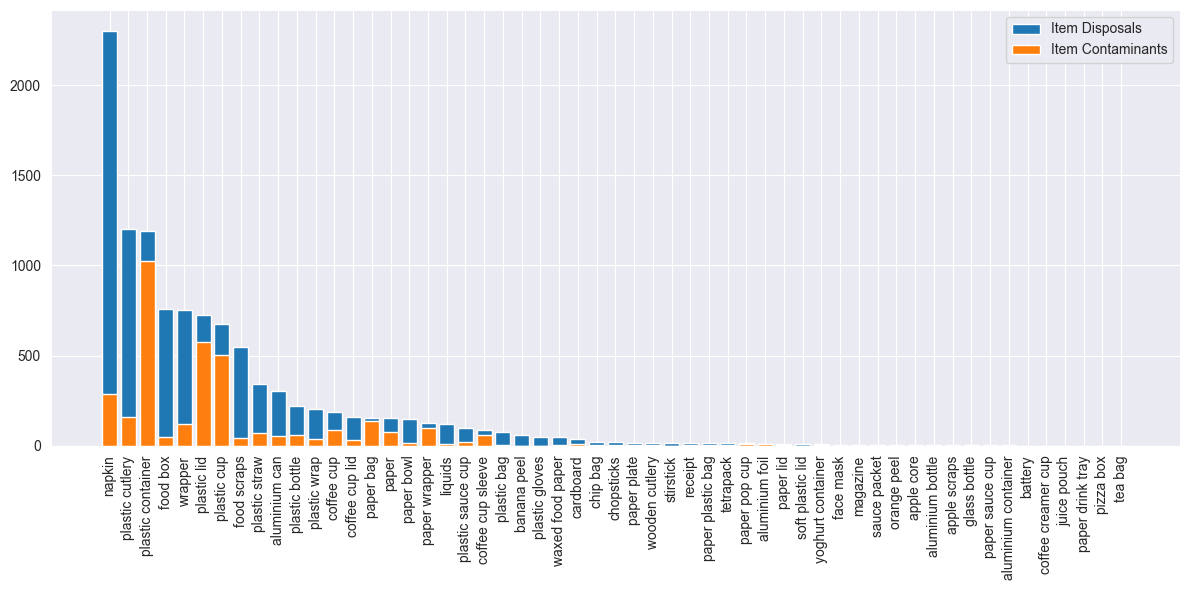

In [56]:
item_contaminant_freqs = disposals.groupby(['Item', 'Correct Bin'])['Contaminants'].sum().sort_values(ascending=False)

item_contaminant_percentages = (item_contaminant_freqs / item_freqs).fillna(0) * 100
item_contaminant_percentages = item_contaminant_percentages.sort_values(ascending=False)

print("Item Contaminant Percentages:")
print(item_contaminant_percentages)

plt.figure(figsize=(12, 6))
x = np.arange(len(item_freqs.index))

plt.bar(x, item_freqs.values, label='Item Disposals')
plt.bar(x, item_contaminant_freqs.reindex(item_freqs.index, fill_value=0).values, label='Item Contaminants')

plt.xticks(x, item_freqs.index.get_level_values('Item'), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Item               Correct Bin
glass bottle       Recycling      100.000000
paper drink tray   Recycling      100.000000
aluminium foil     Recycling       91.666667
paper bag          Recycling       87.662338
plastic container  Recycling       86.073826
dtype: float64

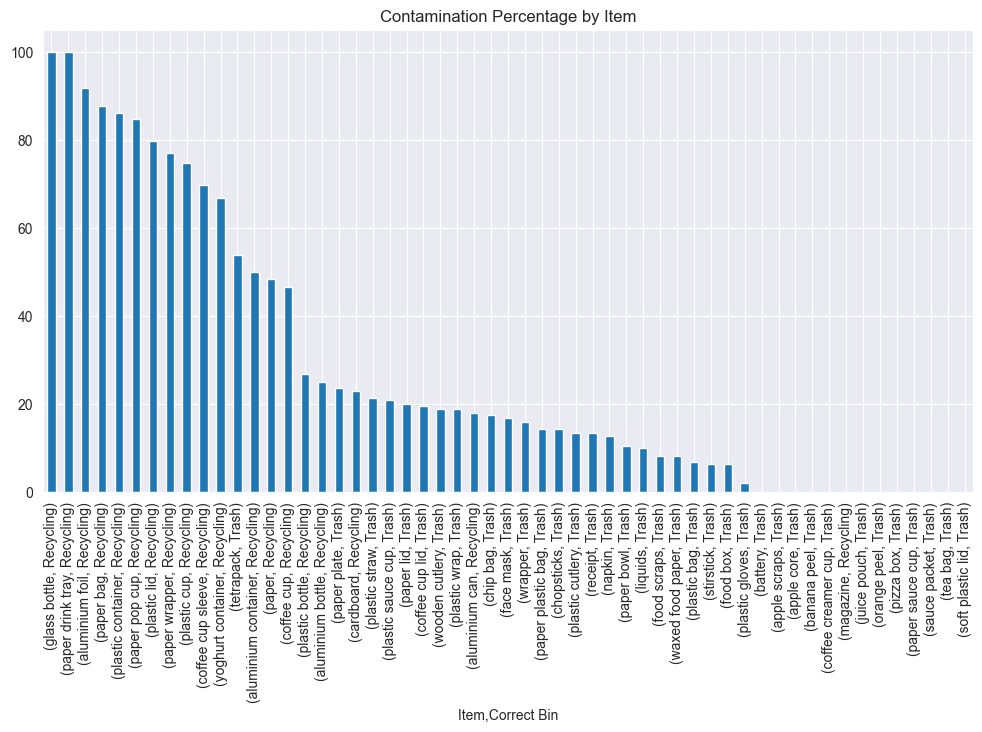

In [57]:
contamination_percentage = (item_contaminant_freqs / item_freqs * 100).sort_values(ascending=False)
contamination_percentage.plot(kind='bar', figsize=(12, 6), title='Contamination Percentage by Item')
display(contamination_percentage.head(5))

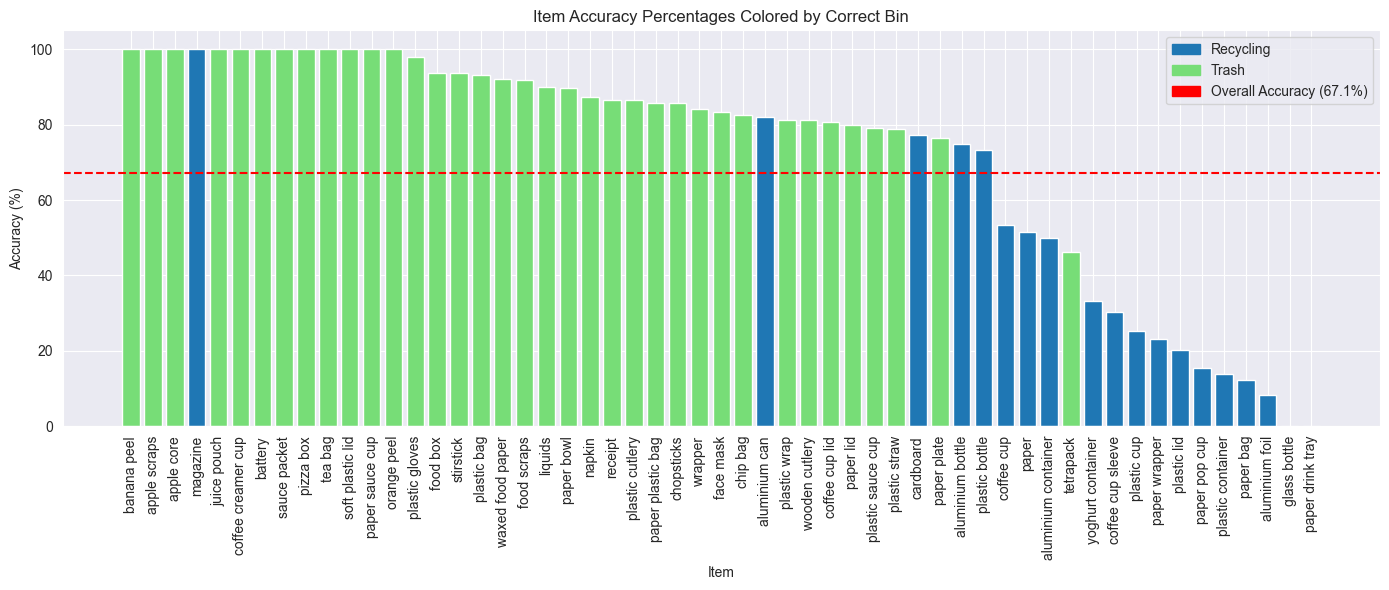

In [58]:
item_accuracy_percentages = ((item_freqs - item_contaminant_freqs) / item_freqs * 100).sort_values(
    ascending=False).reset_index()
item_accuracy_percentages.columns = ['Item', 'Correct Bin', 'Accuracy']

bin_colors = {'Recycling': '#1f77b4', 'Trash': '#77dd77'}
handles = [mpatches.Patch(color=color, label=bin) for bin, color in bin_colors.items()]
colors = item_accuracy_percentages['Correct Bin'].map(bin_colors)

overall_accuracy = ((disposals['Disposals'].sum() - disposals['Contaminants'].sum()) / disposals[
    'Disposals'].sum()) * 100

plt.figure(figsize=(14, 6))
bars = plt.bar(item_accuracy_percentages['Item'], item_accuracy_percentages['Accuracy'], color=colors)
plt.axhline(overall_accuracy, color='red', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.1f}%)')
plt.xticks(rotation=90)
plt.xlabel('Item')
plt.ylabel('Accuracy (%)')
plt.title('Item Accuracy Percentages Colored by Correct Bin')
plt.legend(handles=handles + [mpatches.Patch(color='red', label=f'Overall Accuracy ({overall_accuracy:.1f}%)')])
plt.tight_layout()

### Device-level Disposals and Accuracies

Device
Gordon Dining    4343
U South          4317
Dejope           1812
Mem U             491
Name: Disposals, dtype: int64


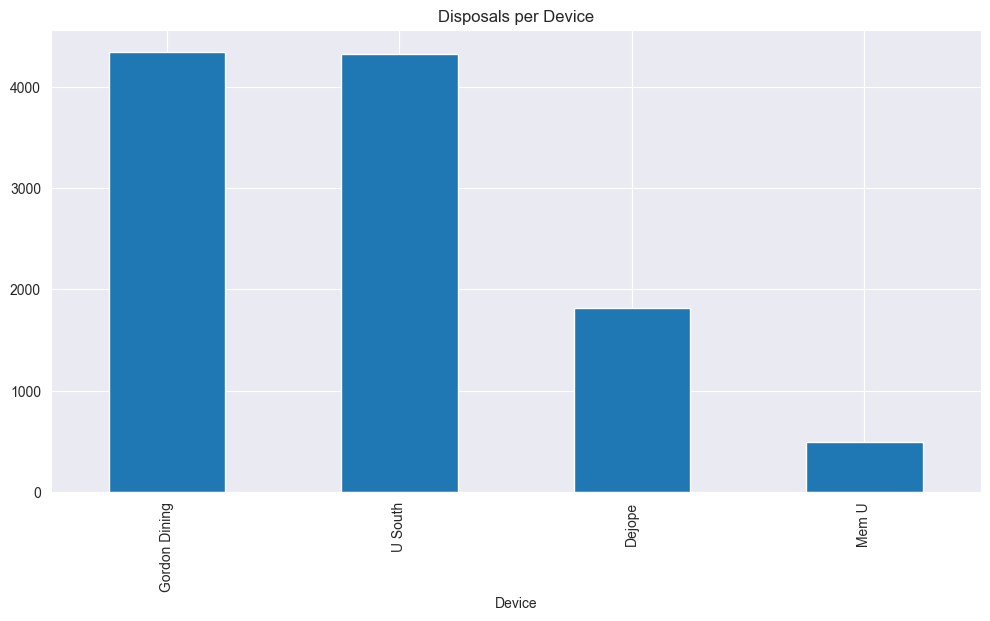

In [59]:
disposals_by_device = disposals.groupby('Device')['Disposals'].sum().sort_values(ascending=False)
disposals_by_device.plot(kind='bar', figsize=(12, 6), title='Disposals per Device')
print(disposals_by_device.head(4))

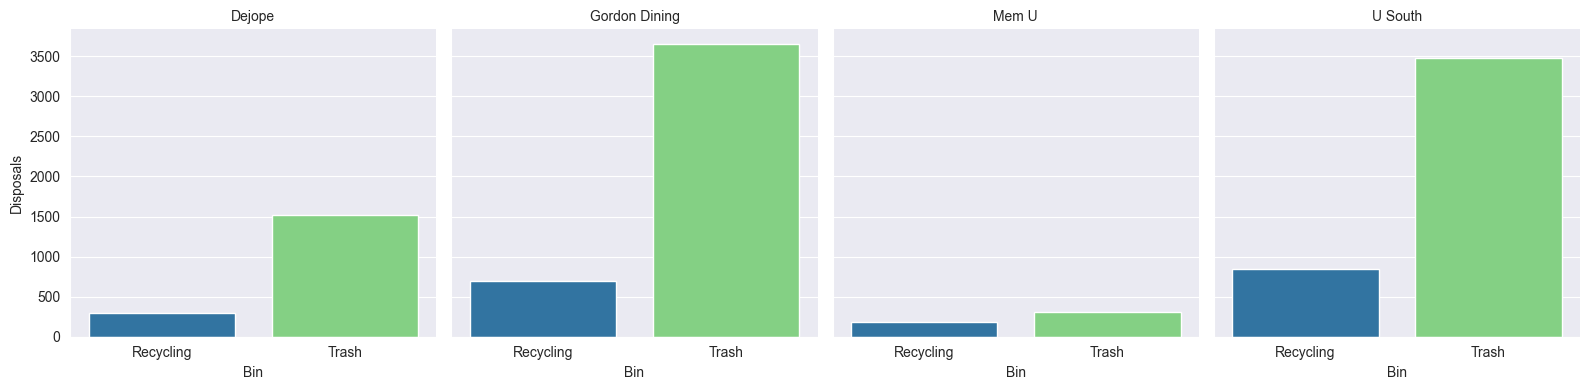

In [60]:
device_by_bin = disposals.groupby(['Device', 'Bin'])['Disposals'].sum().reset_index()
grid = sns.FacetGrid(device_by_bin, col= 'Device', col_wrap=4, height=4)

grid.map_dataframe(sns.barplot, x='Bin', y='Disposals', hue = 'Bin', palette={'Recycling': '#1f77b4', 'Trash': '#77dd77'})

grid.set_titles('{col_name}')
grid.set_axis_labels('Bin', 'Disposals')
plt.tight_layout()
plt.show()

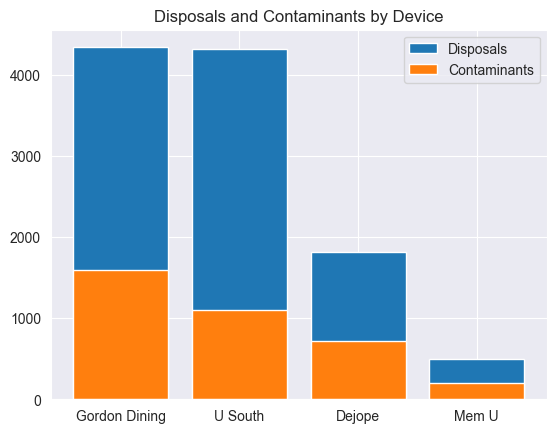

Device
Mem U            40.733198
Dejope           39.403974
Gordon Dining    36.587612
U South          25.573315
dtype: float64

In [61]:
contaminants_by_device = disposals.groupby('Device')['Contaminants'].sum().sort_values(ascending=False)

plt.bar(disposals_by_device.index, disposals_by_device.values, label='Disposals')
plt.bar(contaminants_by_device.index, contaminants_by_device.values, label='Contaminants')
plt.title('Disposals and Contaminants by Device')
plt.legend()
plt.show()

contamination_percentage_by_device = (contaminants_by_device / disposals_by_device * 100).sort_values(ascending=False)
display(contamination_percentage_by_device.head(4))

### Union South Audit Comparison
This data was collected from a manual waste audit performed in December 2024. This data allows us to get a glimpse at what the state of waste sorting on campus was like before the instillation of the Oscar Sort machines. However, we must note that while Oscar Sort is not able to detect soiled recyclables (that are therefore no longer recyclable) the manual waste audit did account for this. For this reason, there may be some compound inconsistency.

In [62]:
audit = pd.read_csv('USouth_waste_audit.csv')
display(audit.head(5))

,Day,Type,Mass (lbs),Total Recyclable (lbs),Contamination Percentage
0,Tue,Garbage,363.57,16.50,4.54
1,Wed,Garbage,257.53,12.10,4.70
2,Thu,Garbage,95.15,4.30,4.52
3,Tue,Recycling,55.98,27.42,48.98
4,Wed,Recycling,16.90,11.50,68.05


In [63]:
# These numbers come directly from the waste audit report
total_usouth_recycle_contamination = 53.40
total_usouth_garbage_contamination = 4.59

In [64]:
usouth = disposals[disposals['Device'] == 'U South']

contamination_by_bin = (usouth.groupby('Bin')['Contaminants'].sum() / usouth.groupby('Bin')['Disposals'].sum()) * 100

contamination_percentages = pd.DataFrame({
    'Type': ['Recycling', 'Garbage', 'Recycling', 'Garbage'],
    'Source': ['Audit', 'Audit', 'Device', 'Device'],
    'Percentage': [53.40, 4.59, contamination_by_bin['Recycling'], contamination_by_bin['Trash']]

})

display(contamination_percentages.head())

,Type,Source,Percentage
0,Recycling,Audit,53.400000
1,Garbage,Audit,4.590000
2,Recycling,Device,41.597139
3,Garbage,Device,21.707878


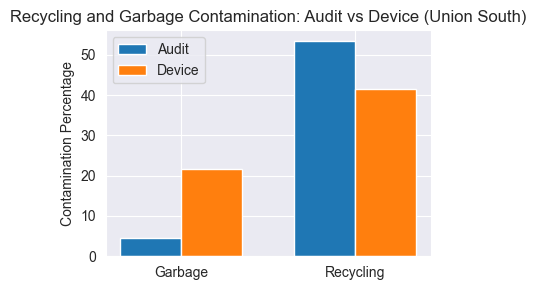

In [65]:
pivot_df = contamination_percentages.pivot(index='Type', columns='Source', values='Percentage')

# Set up bar positions
types = pivot_df.index
x = np.arange(len(types))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, pivot_df['Audit'], width, label='Audit')
ax.bar(x + width/2, pivot_df['Device'], width, label='Device')

ax.set_ylabel('Contamination Percentage')
ax.set_title('Recycling and Garbage Contamination: Audit vs Device (Union South)')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend()
plt.tight_layout()
plt.show()

### Item + Overall Accuracy Correlation

In [66]:
# Get daily accuracy by item
item_daily = disposals.groupby(['Date', 'Item']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
item_daily['Accuracy'] = 1 - (item_daily['Contaminants'] / item_daily['Disposals'])

# Get daily overall accuracy
daily = disposals.groupby('Date').agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
daily['Accuracy'] = 1 - (daily['Contaminants'] / daily['Disposals'])

# Compute correlations between item accuracy and overall accuracy
for item in item_daily['Item'].unique():
    item_data = item_daily[item_daily['Item'] == item]
    # left join item data and daily on item
    item_data = item_data.merge(daily[['Date', 'Accuracy']], on='Date', suffixes=('', '_Overall'))
    if len(item_data) >= 2 and len(item_data['Accuracy'].unique()) > 1:
        # Calculate Pearson correlation coefficient
        correlation, _ = pearsonr(item_data['Accuracy'], item_data['Accuracy_Overall'])
        print(f'Correlation between {item} accuracy and overall accuracy: {correlation:.2f}')

        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = correlation
    else:
        print(f'Not enough data for {item} to calculate correlation.')
        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = 0


Not enough data for apple core to calculate correlation.
Correlation between plastic gloves accuracy and overall accuracy: 0.06
Correlation between plastic wrap accuracy and overall accuracy: 0.40
Correlation between coffee cup accuracy and overall accuracy: 0.34
Correlation between coffee cup lid accuracy and overall accuracy: 0.02
Correlation between coffee cup sleeve accuracy and overall accuracy: 0.14
Correlation between food box accuracy and overall accuracy: -0.33
Correlation between napkin accuracy and overall accuracy: 0.07
Correlation between plastic bag accuracy and overall accuracy: -0.26
Correlation between plastic bottle accuracy and overall accuracy: 0.11
Correlation between plastic container accuracy and overall accuracy: 0.13
Correlation between plastic cup accuracy and overall accuracy: 0.50
Correlation between plastic cutlery accuracy and overall accuracy: -0.12
Correlation between plastic lid accuracy and overall accuracy: 0.59
Correlation between plastic sauce cup a

In [67]:

def f(x):
    item = x


    item_data = item_daily[item_daily['Item'] == item]
    item_data = item_data.merge(daily[['Date', 'Accuracy']], on='Date', suffixes=('', '_Overall'))

    plt.figure(figsize=(12, 6))
    plt.plot(item_data['Date'], item_data['Accuracy'], label=f'{item} Accuracy', marker='o')
    plt.plot(item_data['Date'], item_data['Accuracy_Overall'], label='Overall Accuracy', marker='o')
    plt.title(f'Accuracy Over Time: {item} vs Overall')
    plt.xlabel('Date')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

interact(f, x=disposals['Item'].unique())

interactive(children=(Dropdown(description='x', options=('plastic gloves', 'apple core', 'plastic wrap', 'tetr…

<function __main__.f(x)>

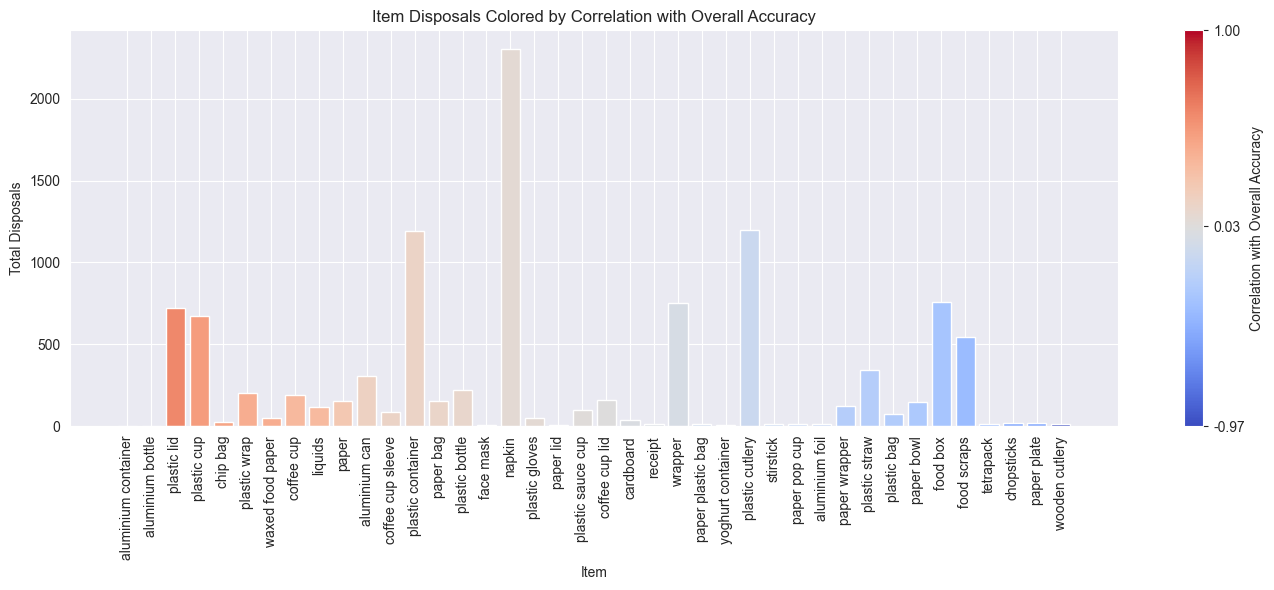

In [68]:
summary = item_daily.groupby('Item').agg({
    'Correlation': 'first',
    'Disposals': 'sum'
}).reset_index()

# Drop rows where correlation is 0 or NaN
summary = summary[(summary['Correlation'] != 0) & (~summary['Correlation'].isna())]

# Sort by correlation
summary = summary.sort_values('Correlation', ascending=False)

# Normalize disposals for colormap
norm = plt.Normalize(vmin=summary['Correlation'].min(), vmax=summary['Correlation'].max())
cmap = plt.cm.coolwarm
colors = cmap(norm(summary['Correlation']))

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(summary['Item'], summary['Disposals'], color=colors)
ax.set_xticks(range(len(summary['Item'])))
ax.set_xticklabels(summary['Item'], rotation=90)
ax.set_xlabel('Item')
ax.set_ylabel('Total Disposals')
ax.set_title('Item Disposals Colored by Correlation with Overall Accuracy')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, label='Correlation with Overall Accuracy', ax=ax)
cbar.set_ticks([summary['Correlation'].min(), summary['Correlation'].median(), summary['Correlation'].max()])
cbar.set_ticklabels([f"{summary['Correlation'].min():.2f}", f"{summary['Correlation'].median():.2f}", f"{summary['Correlation'].max():.2f}"])

plt.tight_layout()
plt.show()

### Disposal Confusion Matrix

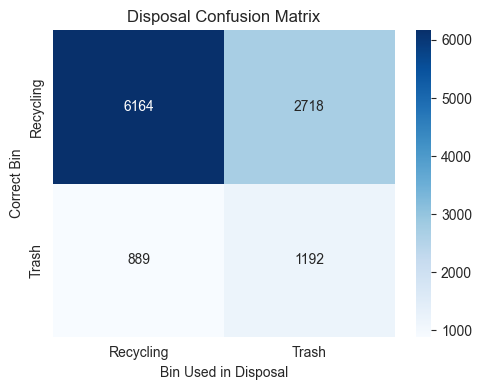

In [69]:
true_garbage = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
false_garbage = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] > 0)]['Disposals'].sum()
true_recycling = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
false_recycling = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] > 0)]['Disposals'].sum()

confusion_matrix = np.array([[true_garbage, false_recycling],[false_garbage, true_recycling]])
conf_df = pd.DataFrame(confusion_matrix, index=['Recycling', 'Trash'], columns=['Recycling', 'Trash'])

plt.figure(figsize=(5, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Disposal Confusion Matrix')
plt.ylabel('Correct Bin')
plt.xlabel('Bin Used in Disposal')
plt.tight_layout()
plt.show()

### Item Association Rule Mining

In [70]:
disposals['Transaction'] = (
   disposals['Date'].astype(str) + '_' +
   disposals['Device'] + '_' +
   disposals['Bin']
)


# Step 2: Create a basket matrix (transactions × items)
basket = (
   disposals
   .groupby(['Transaction', 'Item'])['Disposals']
   .sum()
   .unstack()
   .fillna(0)
)


# Step 3: Binarize the data (presence = 1, absence = 0)
basket = (basket > 0).astype(bool)


basket = basket.loc[:, basket.sum() >= 5]




frequent_itemsets = apriori(basket, min_support=0.1, max_len=2, use_colnames=True)


# Step 5: Generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.75)


# Display top rules
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).to_csv('rules.csv', index=False)



,antecedents,consequents,support,confidence,lift
5,(banana peel),(liquids),0.123810,0.764706,2.549020
16,(coffee cup lid),(coffee cup),0.404762,0.977011,2.182685
15,(coffee cup),(coffee cup lid),0.404762,0.904255,2.182685
29,(coffee cup sleeve),(coffee cup lid),0.223810,0.824561,1.990321
160,(waxed food paper),(plastic wrap),0.109524,0.851852,1.987654
37,(waxed food paper),(coffee cup lid),0.104762,0.814815,1.966794
4,(banana peel),(food scraps),0.152381,0.941176,1.956902
17,(coffee cup sleeve),(coffee cup),0.228571,0.842105,1.881299
12,(banana peel),(plastic wrap),0.128571,0.794118,1.852941
3,(banana peel),(coffee cup lid),0.123810,0.764706,1.845842


In [71]:
#Find association rules with two contaminants

results = pd.DataFrame()

for index, row in rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for a in antecedents:
        for b in consequents:
            if (a in trash_items and b in recycling_items) or (b in trash_items and a in recycling_items):
                results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

results = results.drop_duplicates()
contam_associates_top_10 = results[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)
display(contam_associates_top_10)

,antecedents,consequents,support,confidence,lift
6,(coffee cup),(coffee cup lid),0.404762,0.904255,2.182685
7,(coffee cup lid),(coffee cup),0.404762,0.977011,2.182685
15,(coffee cup sleeve),(coffee cup lid),0.223810,0.824561,1.990321
1,(banana peel),(coffee cup),0.133333,0.823529,1.839800
13,(waxed food paper),(coffee cup),0.104762,0.814815,1.820331
10,(plastic bag),(coffee cup),0.152381,0.780488,1.743643
26,(paper bag),(food scraps),0.257143,0.818182,1.701170
8,(coffee cup),(food scraps),0.342857,0.765957,1.592585
49,(plastic bag),(plastic container),0.185714,0.951220,1.560595
2,(banana peel),(plastic container),0.152381,0.941176,1.544118


In [72]:
def isTrash(item):
    return(item in trash_items)

for index, row in contam_associates_top_10.iterrows():
    output = "If "
    for i in list(row['antecedents']):
        output += i + " (" + ("Trash" if isTrash(i) else "Recycling") + ") "
    output += "is present in a single disposal, "
    for i in list(row['consequents']):
        output += i + " (" + ("Trash" if isTrash(i) else "Recycling") + ") "
    output += "is likely also present."

    display(Markdown((output)))

If coffee cup (Recycling) is present in a single disposal, coffee cup lid (Trash) is likely also present.

If coffee cup lid (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If coffee cup sleeve (Recycling) is present in a single disposal, coffee cup lid (Trash) is likely also present.

If banana peel (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If waxed food paper (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If plastic bag (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If paper bag (Recycling) is present in a single disposal, food scraps (Trash) is likely also present.

If coffee cup (Recycling) is present in a single disposal, food scraps (Trash) is likely also present.

If plastic bag (Trash) is present in a single disposal, plastic container (Recycling) is likely also present.

If banana peel (Trash) is present in a single disposal, plastic container (Recycling) is likely also present.